In [1]:
# Genre Prediction
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras import layers,Model

In [2]:
imageDirectory = 'posters/'
imdb_df = pd.read_csv('finalIMDB1.csv')
imdb_df.rename(columns={'Unnamed: 0':'IMDb_ID'},inplace=True)
imdb_df.tail()

,IMDb_ID,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,IMDb_ID
3995,10094,387892,http://www.imdb.com/title/tt387892,Brodeuses (2004),7.0,Drama|Romance,https://images-na.ssl-images-amazon.com/images...,tt10095
3996,10096,52654,http://www.imdb.com/title/tt52654,The Bridge (1959),7.8,Drama|War,https://images-na.ssl-images-amazon.com/images...,tt10097
3997,10097,263467,http://www.imdb.com/title/tt263467,In the Time of the Butterflies (2001),6.8,Crime|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,tt10098
3998,10098,40740,http://www.imdb.com/title/tt40740,Road House (1948),7.3,Action|Drama|Film-Noir,https://images-na.ssl-images-amazon.com/images...,tt10099
3999,10099,93664,http://www.imdb.com/title/tt93664,Oci ciornie (1987),7.6,Comedy|Romance|Drama,https://images-na.ssl-images-amazon.com/images...,tt10100


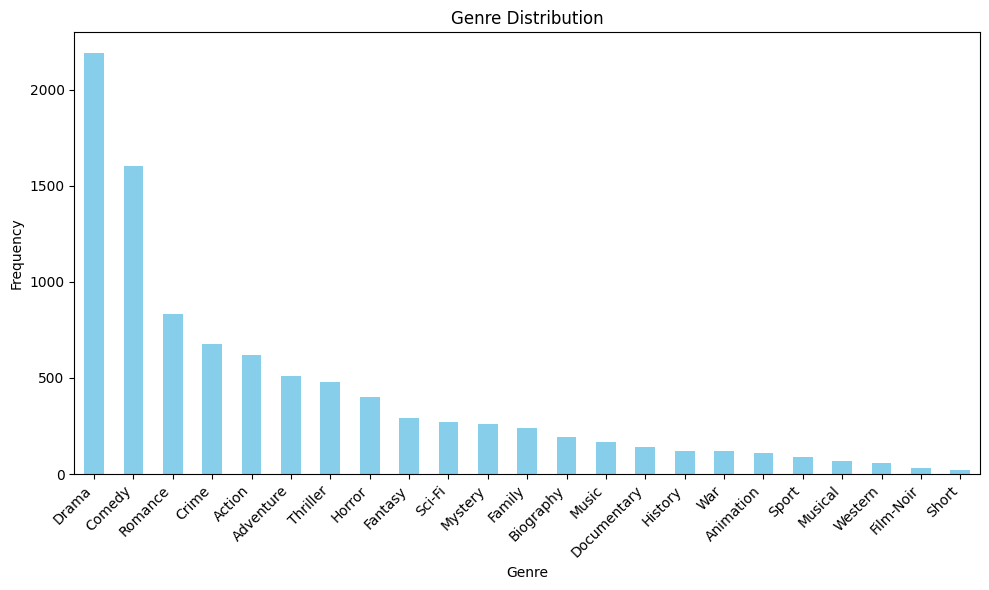

In [3]:
genre_counts = imdb_df['Genre'].str.strip().str.split('|', expand=True).stack().value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
imdb_df['Genre'].dtypes
imdb_df.count()

IMDb_ID       4000
imdbId        4000
Imdb Link     4000
Title         4000
IMDB Score    4000
Genre         3997
Poster        4000
IMDb_ID       4000
dtype: int64

In [5]:
imdb_df['Genre'] = imdb_df['Genre'].fillna('')
imdb_df['Genre'] = imdb_df['Genre'].astype(str)

multiclassBinarizer = MultiLabelBinarizer()
labels = multiclassBinarizer.fit_transform(imdb_df['Genre'].str.split('|'))
imageIds = imdb_df['IMDb_ID']
num_classes = len(multiclassBinarizer.classes_)
print(num_classes)
print(multiclassBinarizer.classes_)
print(labels[:5])

24
['' 'Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Family' 'Fantasy' 'Film-Noir' 'History' 'Horror'
 'Music' 'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Short' 'Sport' 'Thriller'
 'War' 'Western']
[[0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]


In [11]:
image_dir = 'posters/'

image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith('.jpg')]

input_images = []
for image_path in image_paths:
    img = load_img(image_path,target_size=(300,300))
    img_array = img_to_array(img)
    input_images.append(img_array)

input_images = np.array(input_images) / 255.0

print("Data Type:", input_images.dtype)
print("Data Shape:", input_images.shape)

Data Type: float32
Data Shape: (4000, 300, 300, 3)


In [12]:
X_train,X_test,y_train,y_test = train_test_split(input_images, labels, test_size=0.1)
print(labels.shape)


(4000, 24)


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
model = tf.keras.Sequential([
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=X_train[0].shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(24, activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
# train_images, test_images, train_labels, test_labels = train_test_split(input_images, labels, test_size=0.2, random_state=42)

# train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# history = model.fit(
#     X_train,  # Input images for training
#     y_train,  # Corresponding labels for training images
#     epochs=5,  # Adjust batch size as needed
#     validation_data=(X_test, y_test)  # Validation data
# )

# test_loss, test_acc = model.evaluate(test_images, test_labels)
# print(f'Test accuracy: {test_acc}')

# train_images, val_images, train_labels, val_labels = train_test_split(input_images, labels, test_size=0.2)
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=128),
    epochs=5,
    validation_data=(X_test, y_test)
)

Epoch 1/5
21/29 [====================>.........] - ETA: 7:47 - loss: 0.6616 - accuracy: 0.0745